# Deep Q-learning

In [reinforcement learning](http://incompleteideas.net/book/RLbook2020.pdf), we have an agent sequentially interacting with an environment. At each timestep $t$, the agent is in a particular state $S_t$ and selects an action $A_t$. This stochastically results in a reward $R_t$ and a next state $S_{t+1}$, whose probabilities are only dependent on $S_t$ and $A_t$. The reward is immediate feedback on the agent's performance. We call the way in which the agent selects actions the policy. The goal of the agent is

$$\max_\pi \mathbb{E}_\pi\left[\sum_{t=0}^\infty \gamma^t R_{t+1} \right]$$

where $\pi$ is the policy of the agent and $\gamma \in (0,1)$ is the discount factor. The discount factor ensures that the sum is bounded if the rewards are bounded and has the interpretation that future rewards are less valuable than current rewards. Many RL algorithms learn a state-action value function defined to be

$$ Q_\pi(s,a) = \mathbb{E}_\pi\left[ \sum_{t=0}^\infty \gamma^t R_{t+1} \big| S_t = s, A_t = a\right]. $$

These are called Q-values.

Inspired by dyanamic programming, [Q-learning](https://www.gatsby.ucl.ac.uk/~dayan/papers/cjch.pdf) learns the optimal Q-values from the agent's stream of experience by performing the following update at each timestep

$$ Q(S_t, A_t) \leftarrow (1-\alpha) Q(S_t, A_t) + \alpha (R_{t+1} + \gamma \max_{a'} Q(S_{t+1}, a').$$

where $\alpha \in (0,1)$ is an algorithm parameter called the learning rate. In small finite problems, one can represent the Q-values as a lookup table. For problems with a large, possibly infinite, state-space, one may consider representing the Q-values as a deep neural network. We'll call the network that represents the Q-values the Q-network, and train it by regressing to the target $R_{t+1} + \gamma \max_{a'} Q(S_{t+1}, a')$. This has the benefit of expressive power, but at the lack of learning stability.

To address this, Mnih et al. propose [Deep Q-learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) which adds two heuristic improvements which brings the problem of learning the Q-values closer to standard regression. First, they use [experience replay](https://link.springer.com/content/pdf/10.1007/BF00992699.pdf), which uses a sampled batch of prior saved experiences to update the Q-network. Second, they use a past version of the Q-network to compute the targets, updating this "target network" periodically.

## Overview

We'll begin by implementing Deep Q-learning. Then, we'll test it on two environments from the [OpenAI Gym suite](https://gym.openai.com/).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import gym

First, we will need the experience replay buffer. This will be a list of tuples which we will sample from. Our samples will be returned as numpy arrays.

In [2]:
# Experience replay buffer
class Buffer():
    def __init__(self, buffer_size):
        self.buffer = []
        self.buffer_size = buffer_size
        self.buffer_ind = 0
        self.buffer_full = False
    
    def isFull(self):
        return self.buffer_full
        
    def add(self, S, A, R, sPrime, done):
        if not self.buffer_full:
            self.buffer.append((S, A, R, sPrime, done))
            self.buffer_full = (self.buffer_size == len(self.buffer))
        else:
            self.buffer[self.buffer_ind] = (S, A, R, sPrime, done)
            self.buffer_ind += 1
            if self.buffer_ind >= self.buffer_size:
                self.buffer_ind = 0
    
    def sample(self, num):
        inds = np.random.randint(len(self.buffer), size=num)
        S = np.array([self.buffer[x][0] for x in inds])
        A = np.array([self.buffer[x][1] for x in inds])
        R = np.array([self.buffer[x][2] for x in inds])
        sPrime = np.array([self.buffer[x][3] for x in inds])
        done = np.array([self.buffer[x][4] for x in inds])
        
        return S, A, R, sPrime, done

Our Q-network will be a simple feedforward neural network with tanh activations.

In [3]:
# Simple feedforward network
class FFN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=200, hidden_layers=2):
        super().__init__()
        
        seq = []
        # Input layer
        seq.append(nn.Linear(in_dim, hidden_dim))
        seq.append(nn.Tanh())
        # Hidden layers
        for _ in range(hidden_layers-1):
            seq.append(nn.Linear(hidden_dim, hidden_dim))
            seq.append(nn.Tanh())
        # Output layer
        seq.append(nn.Linear(hidden_dim, out_dim))
        
        self.model = nn.Sequential(*seq)
    
    def forward(self, x):
        return self.model(x)     
    
# Helper function for updating target network
def copy_weights(net_from, net_to):
    with torch.no_grad():
        net_to.load_state_dict(net_from.state_dict())

Now let's implement the training function. This will take an OpenAI Gym environment, train the Q-network with Deep Q-learning, and return the trained Q-network. We will first fill the experience replay buffer with random actions to collect diverse experience. The point where we fill the buffer and start training the network will be denoted in the learning curves plot with a vertical dashed line.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(env, \
          hidden_dim=128, \
          hidden_layers=2, \
          discount = 0.99, \
          epsilon = 0.1, \
          num_train_steps = int(2e5), \
          buffer_size = int(5e4), \
          batch_size = 64, \
          target_update_freq = 400, \
          lr = 0.001):

    num_actions = env.action_space.n
    state_size = env.observation_space.high.shape[0]

    # Create network
    net = FFN(state_size, num_actions, hidden_dim=hidden_dim, hidden_layers=hidden_layers)
    net.to(device)

    # Create target network
    target_net = FFN(state_size, num_actions, hidden_dim=hidden_dim, hidden_layers=hidden_layers)
    target_net.to(device)
    copy_weights(net, target_net)

    optim = torch.optim.Adam(net.parameters(), lr=lr)

    # Parameters
    buffer = Buffer(buffer_size)
    target_update_step = 0
    train_step = 0
    log_step = 0
    log_rew = []
    log_buffer_full = None

    while train_step <= num_train_steps:
        S = env.reset()
        done = False
        episode_Rsum = 0

        while not done:
            if buffer.isFull(): # Pick epsilon greedy action
                if np.random.rand() <= epsilon:
                    A = np.random.randint(num_actions)
                else:
                    with torch.no_grad():
                        S_tensor = torch.tensor(S).squeeze().float().to(device)
                        _, ind = net(S_tensor).max(dim=0)
                        A = ind.detach().cpu().numpy()
            else: # Pick random action
                A = np.random.randint(num_actions)

            sPrime, R, done, _ = env.step(A)
            episode_Rsum += R
            train_step += 1
            log_step += 1

            buffer.add(S, A, R, sPrime, done)

            # Update network if buffer is full
            if buffer.isFull():
                # Save training step where buffer was first filled
                if log_buffer_full == None:
                    log_buffer_full = train_step
                    
                # Sample from buffer
                states, actions, rewards, states_prime, dones = \
                    buffer.sample(batch_size)

                states = torch.tensor(states).float().to(device)
                rewards = torch.tensor(rewards).float().to(device)
                states_prime = torch.tensor(states_prime).float().to(device)
                dones = torch.tensor(dones).float().to(device)

                # Compute targets
                with torch.no_grad():
                    qmax_sprime, _ = target_net(states_prime).max(dim=1)
                    targs = rewards + discount*qmax_sprime*(1-dones)

                # Update network
                qs = net(states)[np.arange(batch_size), actions]
                loss = (qs - targs).square().mean()
                optim.zero_grad()
                loss.backward()
                optim.step()            

                # Update target network
                target_update_step += 1
                if target_update_step >= target_update_freq:
                    copy_weights(net, target_net)
                    target_update_step = 0

            S = sPrime

        # Log
        if log_step >= 1000:
            log_step = 0
            log_rew.append((train_step, episode_Rsum))
            if buffer.isFull():
                print('Training step: ' + str(train_step) + ', Reward sum: ' + str(episode_Rsum))
    
    plt.plot([x[0] for x in log_rew], [x[1] for x in log_rew])
    plt.axvline(x=log_buffer_full, color='k', linestyle='--')
    plt.xlabel('Training step')
    plt.ylabel('Reward sum')
    
    return net

OpenAI Gym has the ability to render what the environment looks like to visualize the agent performance. Let's create some helper functions to do this. On my machine, ```env.render(mode='rgb_array')``` is unusually slow, so expect long times.

In [5]:
# Get rendering of performance with trained Q-network
def get_test_frames(env, net, num_episodes=5):
    imgs = []

    for episode in range(num_episodes):
        Rsum = 0
        S = env.reset()
        done = False
        while not done:
            with torch.no_grad():
                S_tensor = torch.tensor(S).squeeze().float().to(device)
                Q, ind = net(S_tensor).max(dim=0)
                A = ind.detach().cpu().numpy()
                Q = Q.detach().cpu().numpy()
            imgs.append((episode, Rsum, Q, np.copy(env.render(mode='rgb_array'))))
            env.close() # Removes strange behavior in rendering window...
            S, R, done, _ = env.step(A)
            Rsum += R
    
    return imgs

In [6]:
# Get rendering of performance with random agent
def get_random_frames(env, num_episodes=5):
    imgs = []
    num_actions = env.action_space.n
    
    for episode in range(num_episodes):
        Rsum = 0
        S = env.reset()
        done = False
        while not done:
            imgs.append((episode, Rsum, None, np.copy(env.render(mode='rgb_array'))))
            env.close() # Removes strange behavior in rendering window...
            S, R, done, _ = env.step(np.random.randint(num_actions))
            Rsum += R
    
    return imgs

In [7]:
# Display the animation in the notebook
def animate_frames(imgs, title, text_color='k'):
    fig, ax = plt.subplots()
    im = plt.imshow(imgs[0][3])
    ep_txt = plt.text(50,50,'Episode = ' + str(0), color=text_color)
    r_txt = plt.text(50,70,'Reward sum = ' + str(0), color=text_color)
    use_Q = imgs[0][2] is not None
    if use_Q:
        Q_txt = plt.text(50,90, 'Q Estimate = ' + str(0), color=text_color)
    plt.axis('off')
    plt.title(title)

    def update(frame):
        ep_txt.set_text('Episode = ' + str(imgs[frame][0]))
        r_txt.set_text('Reward sum = {0:.2f}'.format(imgs[frame][1]))
        if use_Q:
            Q_txt.set_text('Q Estimate = {0:.2f}'.format(imgs[frame][2]))
        im.set_data(imgs[frame][3])
        return im,

    ani = FuncAnimation(fig, update, frames=len(imgs), interval=16)

    plt.close()
    display(HTML(ani.to_html5_video()))

For our first environment, we'll examine [CartPole-v1](https://gym.openai.com/envs/CartPole-v1/). This environment consists of an inverted pendulum attached to a cart on a track. There are two actions that apply a force on the cart to either the left or the right. The agent receives a reward of $+1$ on every timestep. The training episode will be terminated if the pendulum is not within $15$ degrees of vertical, the cart moves off the track, or the episode length limit of $500$ is reached. Due to the episode length limit, the optimal agent behavior collects $500$ reward by keeping the cart centered and the pendulum vertical.

Training step: 50719, Reward sum: 10.0
Training step: 51798, Reward sum: 89.0
Training step: 52840, Reward sum: 93.0
Training step: 53871, Reward sum: 142.0
Training step: 54889, Reward sum: 137.0
Training step: 55954, Reward sum: 197.0
Training step: 57108, Reward sum: 171.0
Training step: 58182, Reward sum: 359.0
Training step: 59319, Reward sum: 241.0
Training step: 60384, Reward sum: 216.0
Training step: 61456, Reward sum: 328.0
Training step: 62667, Reward sum: 231.0
Training step: 63837, Reward sum: 279.0
Training step: 64973, Reward sum: 344.0
Training step: 66143, Reward sum: 474.0
Training step: 67322, Reward sum: 186.0
Training step: 68323, Reward sum: 242.0
Training step: 69422, Reward sum: 249.0
Training step: 70529, Reward sum: 300.0
Training step: 71593, Reward sum: 200.0
Training step: 72737, Reward sum: 200.0
Training step: 73935, Reward sum: 336.0
Training step: 75118, Reward sum: 208.0
Training step: 76225, Reward sum: 236.0
Training step: 77373, Reward sum: 242.0
Tra

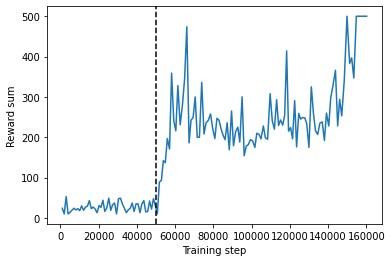

In [8]:
%%time

cp_env = gym.make('CartPole-v1')

train_net = True # Train the network or load it from the file

if train_net:
    cp_net = train(cp_env, hidden_layers=1, num_train_steps = int(1.6e5))
    torch.save(cp_net.state_dict(), 'cp_net.pt')
else:
    num_actions = cp_env.action_space.n
    state_size = cp_env.observation_space.high.shape[0]
    cp_net = FFN(state_size, num_actions, hidden_dim=128, hidden_layers=1)
    cp_net.to(device)
    cp_net.load_state_dict(torch.load('cp_net.pt'))

Now let's visualize the agent's performance.

In [9]:
imgs = get_random_frames(cp_env, num_episodes=3)
animate_frames(imgs, 'Random agent on CartPole-v1')

In [10]:
imgs = get_test_frames(cp_env, cp_net, num_episodes=3)
animate_frames(imgs, 'DQN on CartPole-v1')

The agent succeeds in keeping the pendulum vertical for the full $500$ timesteps.

For our second environment, we'll examine [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/). In this environment there is a lunar lander which is trying to land in a target zone. The actions correspond to using the control thrusters to steer the lander. The agent is rewarded for landing the lander in the target zone while using less fuel. The problem is considered solved if the agent collects over $200$ reward in each episode.

Training step: 50230, Reward sum: -557.2845668545542
Training step: 51320, Reward sum: -433.3663741504248
Training step: 52330, Reward sum: -273.96845711997906
Training step: 53636, Reward sum: -86.1504233546765
Training step: 54992, Reward sum: -53.70460024667265
Training step: 56141, Reward sum: -214.71900103978686
Training step: 57246, Reward sum: -275.2774731520925
Training step: 58420, Reward sum: -123.36867470441956
Training step: 59756, Reward sum: -159.07297799062746
Training step: 61303, Reward sum: -149.29733714639855
Training step: 62303, Reward sum: -105.81979201164806
Training step: 63533, Reward sum: 119.01175119633237
Training step: 64533, Reward sum: -56.104691798561745
Training step: 65533, Reward sum: -34.8961941558357
Training step: 66533, Reward sum: -20.664514198672197
Training step: 67884, Reward sum: -89.0717348030952
Training step: 68884, Reward sum: -36.505076080651904
Training step: 69884, Reward sum: -33.26568601464289
Training step: 71595, Reward sum: -126.5

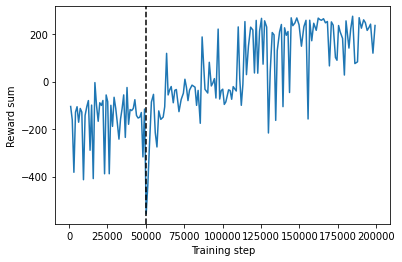

In [11]:
%%time

ll_env = gym.make('LunarLander-v2')

train_net = True # Train the network or load it from the file

if train_net:
    ll_net = train(ll_env, hidden_layers=2, num_train_steps = int(2e5))
    torch.save(ll_net.state_dict(), 'll_net.pt')
else:
    num_actions = ll_env.action_space.n
    state_size = ll_env.observation_space.high.shape[0]
    ll_net = FFN(state_size, num_actions, hidden_dim=128, hidden_layers=2)
    ll_net.to(device)
    ll_net.load_state_dict(torch.load('ll_net.pt'))

Now let's visualize the agent's performance.

In [15]:
imgs = get_random_frames(ll_env, num_episodes=3)
animate_frames(imgs, 'Random agent on LunarLander-v2', text_color='w')

In [17]:
imgs = get_test_frames(ll_env, ll_net, num_episodes=5)
animate_frames(imgs, 'DQN on LunarLander-v2', text_color='w')

The agent has learned to gently land the lander on the pad.

## Conclusion

We reviewed Deep Q-learning and implemented it. We then trained two Q-networks to solve two problems and visualized the learned behavior.